In [3]:
! export JAX_PLATFORMS=cpu

/gpfs/cfel/group/cmi/common/psi4/psi4conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


# Hyperfine solutions for cluster states of H2S 

Compute hyperfine energies, wavefunctions, and spin properties.
Here, calculations will be performed only for rotational cluster states.
The hyperfine effects are modelled by the spin-rotation interaction.


In [4]:
import itertools

import h5py
import hdfdict
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from py3nj import wigner3j
from rovib.cartens import UMAT_SPHER_TO_CART
from rovib.hyperfine_xy2 import dipole_xy2, spin_me_xy2, spinrot_xy2
from rovib.symtop import symtop_on_grid_split_angles
from scipy import constants, stats
from scipy.interpolate import RegularGridInterpolator
from scipy.sparse import csr_matrix
from scipy.spatial.transform import Rotation

SPIN_Y1 = 1 / 2
SPIN_Y2 = 1 / 2

KHZ_TO_INVCM = 1.0 / constants.value("speed of light in vacuum") * 10

DEBYE_TO_AU = (
    1e-21
    / constants.value("speed of light in vacuum")
    / constants.value("elementary charge")
    / constants.value("Bohr radius")
)

DEBYE_X_VM_TO_INVCM = (
    constants.value("atomic unit of electric dipole mom.")
    / (constants.value("Planck constant") * constants.value("speed of light in vacuum"))
    / 1e2
    * DEBYE_TO_AU
)

Read the rovibrational energies and matrix elements of spin-rotation tensors and electric dipole moment from files, computed and stored in `h2s_cart_me_cluster.ipynb` notebook.

In [8]:
pmax = 20
min_j = 50
max_j = 60
tol = 1e-12

print(f"Read energies and quanta for J = {min_j}..{max_j}")

with h5py.File(f"h2s_enr_cluster_pmax{pmax}.h5", "r") as h5:
    enr = hdfdict.load(h5.require_group("energies"), False)
    qua = hdfdict.load(h5.require_group("quanta"), False)
    coefs = hdfdict.load(h5.require_group("coefficients"), False)
    vind = hdfdict.load(h5.require_group("vib-indices"), False)
    rind = hdfdict.load(h5.require_group("rot-indices"), False)

rovib_enr = {
    int(j): {sym: enr_sym for sym, enr_sym in enr_j.items()} for j, enr_j in enr.items()
}

rovib_coefs = {
    int(j): {sym: coefs_sym for sym, coefs_sym in coefs_j.items()}
    for j, coefs_j in coefs.items()
}

rovib_vind = {
    int(j): {sym: vind_sym for sym, vind_sym in vind_j.items()}
    for j, vind_j in vind.items()
}

rovib_rind = {
    int(j): {sym: rind_sym for sym, rind_sym in rind_j.items()}
    for j, rind_j in rind.items()
}

rovib_qua = {
    int(j): {
        sym: np.array(
            [[i] + elem[0].decode("utf-8").split(",") for i, elem in enumerate(qua_sym)]
        )
        for sym, qua_sym in qua_j.items()
    }
    for j, qua_j in qua.items()
}

for j in rovib_enr.keys():
    for sym in rovib_enr[j].keys():
        print(
            f"J = {j}, sym = {sym}, enr = {rovib_enr[j][sym]}, "
            + f"quanta = {rovib_qua[j][sym]}"
        )

print(f"Read spin-rotation and dipole matrix elements for J = {min_j}..{max_j}")

rovib_sr1 = {}
rovib_sr2 = {}
rovib_dipole = {}

for j1 in range(min_j, max_j + 1):
    for j2 in range(min_j, max_j + 1):
        try:
            filename = f"h2s_me_cluster_pmax{pmax}_j{j1}_j{j2}.h5"
            with h5py.File(filename, "r") as h5:
                print(
                    f"read (J1, J2) = {(j1, j2)}, |dJ| = {abs(j1-j2)}, from file {filename}"
                )
                sr1 = hdfdict.load(h5.require_group("spin-rotation-H1"), False)
                sr2 = hdfdict.load(h5.require_group("spin-rotation-H2"), False)
                try:
                    dipole = hdfdict.load(h5.require_group("dipole"), False)
                except ValueError:
                    dipole = {}

                rovib_sr1[(j1, j2)] = {
                    (sym1, sym2): me
                    for sym1, me_sym1 in sr1.items()
                    for sym2, me in me_sym1.items()
                    if np.any(np.abs(me) > tol)
                }

                rovib_sr2[(j1, j2)] = {
                    (sym1, sym2): me
                    for sym1, me_sym1 in sr2.items()
                    for sym2, me in me_sym1.items()
                    if np.any(np.abs(me) > tol)
                }

                rovib_dipole[(j1, j2)] = {
                    (sym1, sym2): me
                    for sym1, me_sym1 in dipole.items()
                    for sym2, me in me_sym1.items()
                    if np.any(np.abs(me) > tol)
                }

        except FileNotFoundError:
            pass

Read energies and quanta for J = 50..60
J = 50, sym = A1, enr = [24708.81890006], quanta = [['0' 'A1' '50' '1' '0' '2' 'B2' '45' '0' 'B2']]
J = 50, sym = A2, enr = [24708.81879579], quanta = [['0' 'A2' '50' '0' '1' '2' 'A1' '35' '1' 'A2']]
J = 50, sym = B1, enr = [24708.81890005], quanta = [['0' 'B1' '50' '0' '1' '2' 'A1' '36' '1' 'B1']]
J = 50, sym = B2, enr = [24708.81879579], quanta = [['0' 'B2' '50' '1' '0' '2' 'B2' '50' '0' 'A1']]
J = 51, sym = A1, enr = [25447.36424769], quanta = [['0' 'A1' '51' '1' '0' '2' 'B2' '31' '0' 'B2']]
J = 51, sym = A2, enr = [25447.36433043], quanta = [['0' 'A2' '51' '2' '0' '0' 'A1' '27' '1' 'A2']]
J = 51, sym = B1, enr = [25447.36424769], quanta = [['0' 'B1' '51' '2' '0' '0' 'A1' '26' '1' 'B1']]
J = 51, sym = B2, enr = [25447.36433042], quanta = [['0' 'B2' '51' '1' '0' '2' 'B2' '26' '0' 'A1']]
J = 52, sym = A1, enr = [26191.9451634], quanta = [['0' 'A1' '52' '0' '2' '0' 'B2' '13' '0' 'B2']]
J = 52, sym = A2, enr = [26191.94505483], quanta = [['0' 'A2'

Compute hyperfine energies and wavefunctions

In [9]:
hyper_qua = {}
hyper_qua_block = {}
hyper_enr = {}
hyper_vec = {}

for f in (60,):

    j = f

    ham_sr, hyper_qua[f], hyper_qua_block[f] = spinrot_xy2(
        f,
        {j: rovib_enr[j]},
        {j: rovib_qua[j]},
        {(j, j): rovib_sr1[(j, j)]},
        {(j, j): rovib_sr2[(j, j)]},
        spin_states=((0, "B2"), (1, "A1")),
        spins=(SPIN_Y1, SPIN_Y2),
    )

    hyper_enr[f] = {}
    hyper_vec[f] = {}

    for sym, qua_sym in hyper_qua_block[f].items():
        h0 = np.diag(
            np.concatenate(
                np.array([rovib_enr[int(j)][rov_sym] for (j, rov_sym, *_) in qua_sym]),
                axis=-1,
            )
        )

        h = h0 + ham_sr[sym]
        enr, vec = np.linalg.eigh(h)

        for e, v in zip(enr, vec.T):
            ind = np.argmax(v**2)
            print(
                f"F = {f}, sym = {sym}, enr = {e}, shift (kHz) = {(e - h0[ind, ind]) / KHZ_TO_INVCM}, "
                + f"leading quanta = {hyper_qua[f][sym][ind]}, |c|**2 = {np.abs(v[ind])**2}"
            )

        hyper_enr[f][sym] = enr
        hyper_vec[f][sym] = vec

F = 60, sym = B1, enr = 32309.804146753235, shift (kHz) = -1121.4443506166747, leading quanta = ['60' 'B1' '1' 'A1' '0' 'B1' '60' '0' '2' '1' 'B2' '5' '1' 'A2'], |c|**2 = 0.5037201662789867
F = 60, sym = B1, enr = 32309.804221072744, shift (kHz) = 1105.7327198831722, leading quanta = ['60' 'A2' '0' 'B2' '0' 'A2' '60' '0' '2' '1' 'B2' '10' '1' 'B1'], |c|**2 = 0.5037201662789867
F = 60, sym = B2, enr = 32309.804146757204, shift (kHz) = -1122.370520923208, leading quanta = ['60' 'B2' '1' 'A1' '0' 'B2' '60' '1' '1' '1' 'A1' '47' '0' 'B2'], |c|**2 = 0.5033015852950887
F = 60, sym = B2, enr = 32309.80422107628, shift (kHz) = 1106.6588901897055, leading quanta = ['60' 'A1' '0' 'B2' '0' 'A1' '60' '1' '1' '1' 'A1' '34' '0' 'A1'], |c|**2 = 0.5033015852950887


Compute the effect of external static electric field, polarized along the laboratory $Z$ axis.

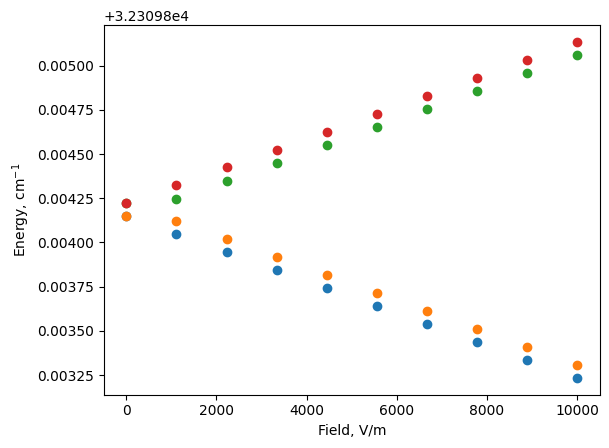

In [10]:
f = 60
m_f = f

dip_me, dip_qua = dipole_xy2(
    {f: hyper_qua_block[f]}, hyper_vec, rovib_dipole, m_val=m_f
)

h0 = np.diag(
    [hyper_enr[float(f_)][sym_][int(istate_)] for (f_, m_, sym_, istate_) in dip_qua]
)

field = np.linspace(0, 1000, 10) * 10  # in V/m stark_enr = []
hyper_stark_vec = []
hyper_stark_enr = []
for fz in field:
    h = h0 - dip_me[-1] * fz * DEBYE_X_VM_TO_INVCM
    e, v = np.linalg.eigh(h)
    hyper_stark_enr.append(e)
    hyper_stark_vec.append(v)
hyper_stark_enr = np.array(hyper_stark_enr)
hyper_stark_vec = np.array(hyper_stark_vec)

# plot Stark energies

for e in hyper_stark_enr.T:
    plt.scatter(field, e)
plt.ylabel("Energy, cm$^{-1}$")
plt.xlabel("Field, V/m")
plt.show()

Stark effect for rovibrational states

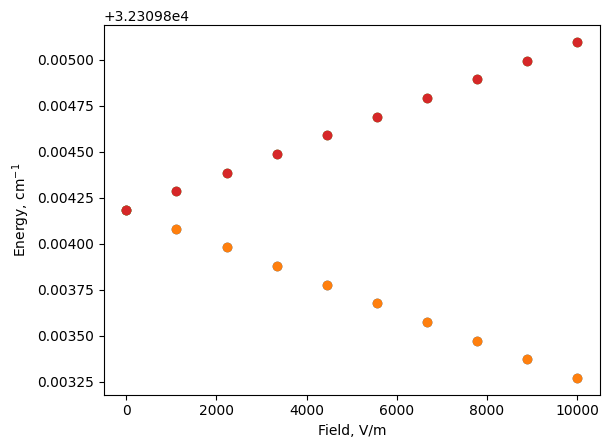

In [11]:
j = 60
m_j = j

mmat = (
    (-1) ** m_j
    * np.sqrt((2 * j + 1) * (2 * j + 1))
    * np.dot(
        UMAT_SPHER_TO_CART[1],
        np.array(
            [
                wigner3j(j * 2, 2, j * 2, m_j * 2, sigma, -m_j * 2)
                for sigma in (-1, 0, 1)
            ]
        ),
    )
)

rovib_dip_me = []
rovib_dip_qua = []
for sym1 in rovib_qua[j].keys():
    row = []
    rovib_dip_qua += [(j, m_j, sym1, i) for i in range(len(rovib_enr[j][sym1]))]
    for sym2 in rovib_qua[j].keys():
        try:
            kmat = rovib_dipole[(j, j)][(sym1, sym2)][:, :, 0]
        except KeyError:
            kmat = np.zeros((len(rovib_enr[j1][sym1]), len(rovib_enr[j2][sym2])))
        row.append(kmat)
    rovib_dip_me.append(np.concatenate(row, axis=-1))
rovib_dip_me = np.concatenate(rovib_dip_me, axis=0)[None, :, :] * mmat[:, None, None]

h0 = np.diag(np.concatenate([rovib_enr[j][sym] for sym in rovib_qua[j].keys()], axis=0))

field = np.linspace(0, 1000, 10) * 10  # in V/m
rovib_stark_enr = []
rovib_stark_vec = []
for fz in field:
    h = h0 - rovib_dip_me[-1] * fz * DEBYE_X_VM_TO_INVCM
    e, v = np.linalg.eigh(h)
    rovib_stark_enr.append(e)
    rovib_stark_vec.append(v)
rovib_stark_enr = np.array(rovib_stark_enr)
rovib_stark_vec = np.array(rovib_stark_vec)

# plot Stark energies

for e in rovib_stark_enr.T:
    plt.scatter(field, e)
plt.ylabel("Energy, cm$^{-1}$")
plt.xlabel("Field, V/m")
plt.show()

## Nuclear-spin density

In [12]:
def psi_on_grid(j: int, vib_ind, rot_ind, coefs, alpha, beta, gamma):
    """Computes rovibrational function for selected states on grid of Euler angles"""
    rot_k, rot_m, rot_mu, k_list, jktau_list = symtop_on_grid_split_angles(
        j, alpha, beta, gamma
    )
    rot_k = rot_k[rot_ind]
    vib_ind_unique = list(set(vib_ind))
    v_ind = [np.where(vib_ind == ind)[0] for ind in vib_ind_unique]
    unique_vec = np.zeros((len(vib_ind), len(vib_ind_unique)))
    for i, v in enumerate(v_ind):
        unique_vec[v, i] = 1
    rot_kv = np.einsum("i...,img,iv->mvg...", coefs, rot_k, unique_vec, optimize="optimal")
    return rot_kv, rot_m, rot_mu, enr, vib_ind_unique

In [13]:
def monte_carlo_distr(npoints, alpha, beta, gamma, dens, xyz):
    fdens = RegularGridInterpolator((alpha, beta, gamma), dens)
    points = np.random.uniform(
        low=[0, 0, 0], high=[2 * np.pi, np.pi, 2 * np.pi], size=(npoints, 3)
    )
    w = fdens(points)
    signs = np.sign(w)
    abs_w = np.abs(w) / np.max(np.abs(dens))
    eta = np.random.uniform(0.0, 1.0, size=len(w))
    ind = np.where(abs_w > eta)
    points = points[ind]
    signs = signs[ind]
    rotmat = Rotation.from_euler("ZYZ", points).as_matrix()
    xyz_sample = np.dot(rotmat, xyz)
    kernel = stats.gaussian_kde(xyz_sample.T)
    weights = kernel(xyz_sample.T)
    return xyz_sample, weights, signs

In [14]:
npoints = 30
alpha = np.linspace(0, 2 * np.pi, npoints)
beta = np.linspace(0, np.pi, npoints)
gamma = np.linspace(0, 2 * np.pi, npoints)
euler_grid = np.array([elem for elem in itertools.product(alpha, beta, gamma)])

In [15]:
atom_xyz = np.array(
    [
        [8.82173006e-01, 0.00000000e00, 9.71108730e-01],
        [8.82173006e-01, 0.00000000e00, -9.71108730e-01],
    ]
)
atom_xyz = atom_xyz / np.linalg.norm(atom_xyz, axis=-1)[:, None]

In [16]:
psi = []
for i, (j, m, sym, ind) in enumerate(rovib_dip_qua):
    rot_kv, rot_m, rot_mu, enr, vib_ind = psi_on_grid(
        j,
        rovib_vind[j][sym],
        rovib_rind[j][sym],
        rovib_coefs[j][sym][:, ind],
        alpha,
        beta,
        gamma,
    )
    psi.append((rot_kv, rot_m, rot_mu, enr, vib_ind))

dens = np.zeros((len(psi), len(psi), npoints, npoints, npoints), dtype=np.complex128)

for i1, (rot_kv1, rot_m1, rot_mu1, enr1, vib_ind1) in enumerate(psi):
    for i2, (rot_kv2, rot_m2, rot_mu2, enr2, vib_ind2) in enumerate(psi):
        vib_ind12 = list(set(vib_ind1) & set(vib_ind2))
        vi1 = [vib_ind1.index(v) for v in vib_ind12]
        vi2 = [vib_ind2.index(v) for v in vib_ind12]
        diff = list(set(vib_ind1) - set(vib_ind2))
        assert len(diff) == 0, (
            f"different lists of vib quanta for basis states (ibra, iket) = {(i1, i2)},"
            + f"diff: {diff}"
        )
        den_kv = np.einsum(
            "ivg,jvg->ijg",
            np.conj(rot_kv1[:, vi1]),
            rot_kv2[:, vi2],
            optimize="optimal",
        )
        den_m = np.einsum("mig,mjg->mijg", np.conj(rot_m1), rot_m2, optimize="optimal")
        den_mu = np.einsum("ig,jg->ijg", np.conj(rot_mu1), rot_mu2, optimize="optimal")
        dens[i1, i2] = np.einsum(
            "ijg,ija,ijb,b->abg",
            den_kv,
            den_m[-1],
            den_mu,
            np.sin(beta),
            optimize="optimal",
        )

stark_dens = np.einsum(
    "fik,ij...,fjk->fk...",
    np.conj(rovib_stark_vec),
    dens,
    rovib_stark_vec,
    optimize="optimal",
)

atom 0


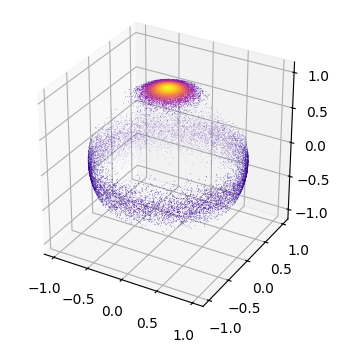

atom 1


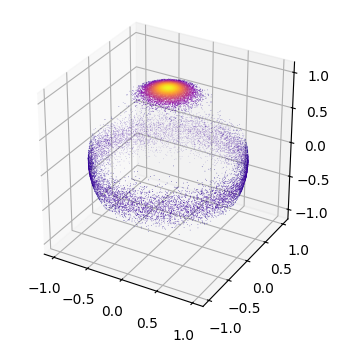

In [17]:
for i, xyz in enumerate(atom_xyz):
    print(f"atom {i}")
    xyz_samples, weights, signs = monte_carlo_distr(
        1000000, alpha, beta, gamma, stark_dens[-1, 0], xyz
    )

    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(projection="3d")
    ax.set_box_aspect(aspect=(1, 1, 1))
    ax.axes.set_xlim3d(left=-1.1, right=1.1)
    ax.axes.set_ylim3d(bottom=-1.1, top=1.1)
    ax.axes.set_zlim3d(bottom=-1.1, top=1.1)

    ax.scatter(
        *xyz_samples.T, c=weights, s=1, edgecolor="none", marker=".", cmap="plasma"
    )
    plt.show()

Rotational density for hyperfne cluster states

In [18]:
dens = {}  # dens[(sym1, sym2)]

# precompute wavefunctions on Euler grid and contract them with three-j symbols

psi_threej = {}  # psi_threej[sym]

for sym in hyper_qua[f].keys():

    print(
        f"compute hyperfine wavefunctions for F = {f}, sym = {sym}, no. states = {len(hyper_qua[f][sym])}"
    )

    p = f + m_f
    ip = int(p)
    assert abs(p - ip) < 1e-16, f"F + m_f: {f} + {m_f} = {p} is not an integer number"
    prefac = (-1) ** p * np.sqrt(2 * f + 1)

    psi = []

    for rov_qua in hyper_qua[f][sym]:
        j = int(rov_qua[0])
        rov_sym = rov_qua[1]
        i = int(rov_qua[2])
        rov_state_ind = int(rov_qua[4])

        mi = np.linspace(-i, i, int(2 * i) + 1)
        mj = np.arange(-j, j + 1)
        mij = np.concatenate(
            (
                mi[:, None, None].repeat(len(mj), axis=1),
                mj[None, :, None].repeat(len(mi), axis=0),
            ),
            axis=-1,
        ).reshape(-1, 2)
        n = len(mij)
        two_mi, two_mj = mij.T * 2

        threej = wigner3j(
            [f * 2] * n,
            [i * 2] * n,
            [j * 2] * n,
            [-m_f * 2] * n,
            two_mi.astype(int),
            two_mj.astype(int),
            ignore_invalid=True,
        ).reshape(len(mi), len(mj))

        rot_kv, rot_m, rot_mu, enr, vib_ind = psi_on_grid(
            j,
            rovib_vind[j][rov_sym],
            rovib_rind[j][rov_sym],
            rovib_coefs[j][rov_sym][:, rov_state_ind],
            alpha,
            beta,
            gamma,
        )
        rot_m = np.einsum("nm,mig->nig", threej, rot_m, optimize="optimal") * prefac
        psi.append((rot_kv, rot_m, rot_mu, vib_ind, i))

    psi_threej[sym] = psi

# compute densities

for sym1, psi1 in psi_threej.items():
    for sym2, psi2 in psi_threej.items():

        print(f"compute hyperfine densities for F = {f}, (sym1, sym2) = {(sym1, sym2)}")

        # compute density in the product basis of rovibrational and spin functions

        prim_dens = np.zeros(
            (len(psi1), len(psi2), npoints, npoints, npoints), dtype=np.complex128
        )

        for ibra, (rot_kv1, rot_m1, rot_mu1, vib_ind1, i1) in enumerate(psi1):
            for iket, (rot_kv2, rot_m2, rot_mu2, vib_ind2, i2) in enumerate(psi2):
                if i1 != i2:
                    continue
                vib_ind12 = list(set(vib_ind1) & set(vib_ind2))
                vi1 = [vib_ind1.index(v) for v in vib_ind12]
                vi2 = [vib_ind2.index(v) for v in vib_ind12]
                diff = list(set(vib_ind1) - set(vib_ind2))
                assert len(diff) == 0, (
                    f"different lists of vib quanta for basis states (ibra, iket) = {(i1, i2)},"
                    + f"diff: {diff}"
                )

                den_kv = np.einsum(
                    "ivg,jvg->ijg",
                    np.conj(rot_kv1[:, vi1]),
                    rot_kv2[:, vi2],
                    optimize="optimal",
                )
                den_m = np.einsum(
                    "mig,mjg->ijg", np.conj(rot_m1), rot_m2, optimize="optimal"
                )
                den_mu = np.einsum(
                    "ig,jg->ijg", np.conj(rot_mu1), rot_mu2, optimize="optimal"
                )
                prim_dens[ibra, iket] = np.einsum(
                    "ijg,ija,ijb,b->abg",
                    den_kv,
                    den_m,
                    den_mu,
                    np.sin(beta),
                    optimize="optimal",
                )

        # transform density to basis of hyperfine states

        dens[(sym1, sym2)] = np.einsum(
            "ik,ij...,jl->kl...",
            np.conj(hyper_vec[f][sym1]),
            prim_dens,
            hyper_vec[f][sym2],
            optimize="optimal",
        )

        # dens[(sym1, sym2)] = prim_dens

compute hyperfine wavefunctions for F = 60, sym = B1, no. states = 2


compute hyperfine wavefunctions for F = 60, sym = B2, no. states = 2
compute hyperfine densities for F = 60, (sym1, sym2) = ('B1', 'B1')
compute hyperfine densities for F = 60, (sym1, sym2) = ('B1', 'B2')
compute hyperfine densities for F = 60, (sym1, sym2) = ('B2', 'B1')
compute hyperfine densities for F = 60, (sym1, sym2) = ('B2', 'B2')


In [23]:
dens = {}  # dens[(sym1, sym2)]

# precompute wavefunctions on Euler grid and contract them with three-j symbols

psi_threej = {}  # psi_threej[sym]

for sym in hyper_qua[f].keys():

    print(
        f"compute hyperfine wavefunctions for F = {f}, sym = {sym}, no. states = {len(hyper_qua[f][sym])}"
    )

    p = f + m_f
    ip = int(p)
    assert abs(p - ip) < 1e-16, f"F + m_f: {f} + {m_f} = {p} is not an integer number"
    prefac = (-1) ** p * np.sqrt(2 * f + 1)

    psi = []

    for rov_qua in hyper_qua[f][sym]:
        rov_state_ind = int(rov_qua[4])
        rov_sym = rov_qua[1]
        j = int(rov_qua[0])
        i = int(rov_qua[2])

        two_mi, two_mj = np.array(
            [
                (int(mi * 2), int(mj * 2))
                for mi in np.linspace(-i, i, int(2 * i) + 1)
                for mj in range(-j, j + 1)
            ]
        ).T
        nelem = len(two_mi)
        threej = wigner3j(
            [f * 2] * nelem,
            [i * 2] * nelem,
            [j * 2] * nelem,
            [-m_f * 2] * nelem,
            two_mi,
            two_mj,
            ignore_invalid=True,
        ).reshape(2 * i + 1, 2 * j + 1)

        # rot_kv, rot_m, rot_mu, enr, vib_qua = psi_on_grid(
        #     j, rov_sym, rov_state_ind, alpha, beta, gamma
        # )
        # rot_m = np.einsum("nm,mig->nig", threej, rot_m, optimize="optimal") * prefac
        # psi.append((rot_kv, rot_m, rot_mu, vib_qua, i))
        rot_kv, rot_m, rot_mu, enr, vib_ind = psi_on_grid(
            j,
            rovib_vind[j][rov_sym],
            rovib_rind[j][rov_sym],
            rovib_coefs[j][rov_sym][:, rov_state_ind],
            alpha,
            beta,
            gamma,
        )
        rot_m = np.einsum("nm,mig->nig", threej, rot_m, optimize="optimal") * prefac
        psi.append((rot_kv, rot_m, rot_mu, vib_ind, i))

    psi_threej[sym] = psi

# compute densities

for sym1, psi1 in psi_threej.items():
    for sym2, psi2 in psi_threej.items():

        print(f"compute hyperfine densities for F = {f}, (sym1, sym2) = {(sym1, sym2)}")

        # compute density in the product basis of rovibrational and spin functions

        prim_dens = np.zeros(
            (len(psi1), len(psi2), npoints, npoints, npoints, 3, 2),
            dtype=np.complex128,
        )

        for ibra, (rot_kv1, rot_m1, rot_mu1, vib_qua1, i1) in enumerate(psi1):
            for iket, (rot_kv2, rot_m2, rot_mu2, vib_qua2, i2) in enumerate(psi2):
                # vib_qua12 = list(set(vib_qua1) & set(vib_qua2))
                # vib_ind1 = [vib_qua1.index(v) for v in vib_qua12]
                # vib_ind2 = [vib_qua2.index(v) for v in vib_qua12]
                # diff = list(set(vib_qu)
                vib_ind12 = list(set(vib_ind1) & set(vib_ind2))
                vi1 = [vib_ind1.index(v) for v in vib_ind12]
                vi2 = [vib_ind2.index(v) for v in vib_ind12]
                diff = list(set(vib_ind1) - set(vib_ind2))
                assert len(diff) == 0, (
                    f"different lists of vib quanta for basis states (ibra, iket) = {(ibra, iket)},"
                    + f"diff: {diff}"
                )

                spin_me = spin_me_xy2(i1, i2, SPIN_Y1, SPIN_Y2)

                den_kv = np.einsum(
                    "ivg,jvg->ijg",
                    np.conj(rot_kv1[:, vib_ind1]),
                    rot_kv2[:, vib_ind2],
                    optimize="optimal",
                )
                den_m = np.einsum(
                    "mig,mn...,njg->ijg...",
                    np.conj(rot_m1),
                    spin_me,
                    rot_m2,
                    optimize="optimal",
                )
                den_mu = np.einsum(
                    "ig,jg->ijg", np.conj(rot_mu1), rot_mu2, optimize="optimal"
                )
                prim_dens[ibra, iket] = np.einsum(
                    "ijg,ija...,ijb,b->abg...",
                    den_kv,
                    den_m,
                    den_mu,
                    np.sin(beta),
                    optimize="optimal",
                )

        # transform density to basis of hyperfine states

        dens[(sym1, sym2)] = np.einsum(
            "ik,ij...,jl->kl...",
            np.conj(hyper_vec[f][sym1]),
            prim_dens,
            hyper_vec[f][sym2],
            optimize="optimal",
        )

compute hyperfine wavefunctions for F = 60, sym = B1, no. states = 2
compute hyperfine wavefunctions for F = 60, sym = B2, no. states = 2
compute hyperfine densities for F = 60, (sym1, sym2) = ('B1', 'B1')
compute hyperfine densities for F = 60, (sym1, sym2) = ('B1', 'B2')
compute hyperfine densities for F = 60, (sym1, sym2) = ('B2', 'B1')
compute hyperfine densities for F = 60, (sym1, sym2) = ('B2', 'B2')


In [24]:
key0 = list(dens.keys())[0]
stark_dens = np.zeros(
    (len(dip_qua), len(dip_qua), *dens[key0].shape[2:]), dtype=np.complex128
)

for i1, (f1, m_f1, sym1, ind1) in enumerate(dip_qua):
    iind1 = int(ind1)
    for i2, (f2, m_f2, sym2, ind2) in enumerate(dip_qua):
        assert f1 == str(f) and f2 == str(
            f
        ), f"`dens` is computed for fixed f = {f} != {f1} or {f2}"
        assert m_f1 == str(m_f) and m_f2 == str(
            m_f
        ), f"`dens` is computed for fixed m_f = {m_f} != {m_f1} or {m_f2}"
        iind2 = int(ind2)
        stark_dens[i1, i2] = dens[(sym1, sym2)][iind1, iind2]

stark_dens = np.einsum(
    "fik,ij...,fjk->fk...",
    np.conj(hyper_stark_vec),
    stark_dens,
    hyper_stark_vec,
    optimize="optimal",
)

print("max imag component of density:", np.max(np.abs(np.imag(stark_dens))))
# stark_dens = np.abs(stark_dens)
for v in hyper_stark_vec[-1]:
    print(np.round(v,3))

max imag component of density: 2.9631409486662367e-17
[-0.707-0.j  0.001-0.j  0.707+0.j -0.001+0.j]
[0.001+0.j 0.707+0.j 0.001-0.j 0.707-0.j]
[-0.-0.707j -0.+0.001j  0.-0.707j  0.+0.001j]
[-0.-0.001j -0.-0.707j  0.+0.001j  0.+0.707j]


32309.80323429009
state index: 0


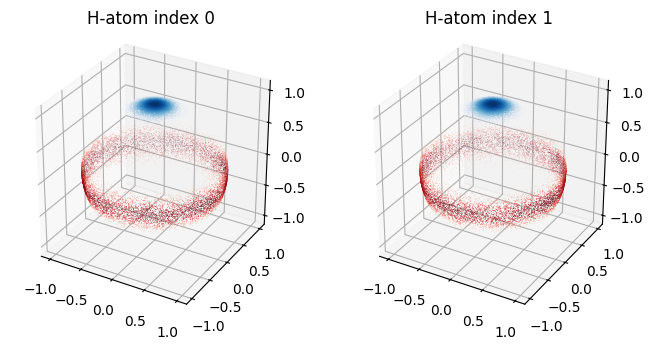

32309.80330860805
state index: 1


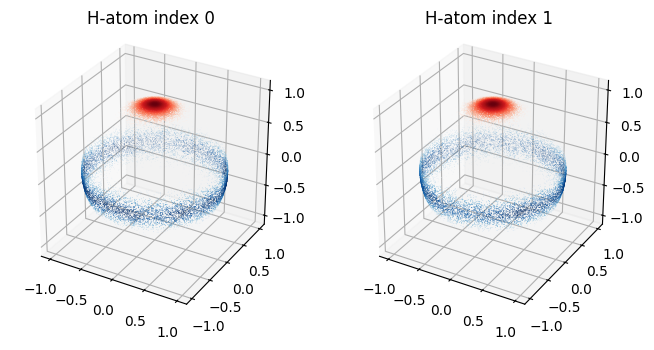

32309.805059219932
state index: 2


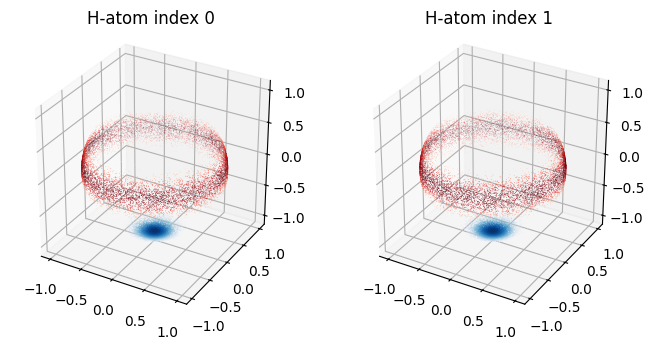

32309.805133541395
state index: 3


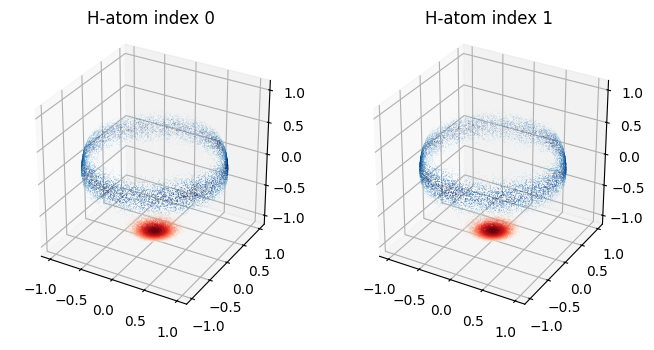

In [30]:
for istate, state_dens in enumerate(stark_dens[-1]):
    print(hyper_stark_enr[-1][istate])

    print("state index:", istate)
    # if istate >= 1:
    #     continue

    fig = plt.figure(figsize=(8, 8))
    axs = [
        fig.add_subplot(1, 2, 1, projection="3d"),
        fig.add_subplot(1, 2, 2, projection="3d"),
    ]
    for ax in axs:
        ax.set_box_aspect(aspect=(1, 1, 1))
        ax.axes.set_xlim3d(left=-1.1, right=1.1)
        ax.axes.set_ylim3d(bottom=-1.1, top=1.1)
        ax.axes.set_zlim3d(bottom=-1.1, top=1.1)

    for i, (xyz, ax) in enumerate(zip(atom_xyz, axs)):
        dz = state_dens[:, :, :, -1, i]
        # dz = state_dens[:, :, :]
        xyz_samples, weights, signs = monte_carlo_distr(
            1000000, alpha, beta, gamma, dz, xyz
        )

        pos_ind = np.where(signs > 0)
        neg_ind = np.where(signs < 0)
        ax.set_title(f"H-atom index {i}")

        ax.scatter(
            *xyz_samples[pos_ind].T,
            c=weights[pos_ind],
            s=1,
            edgecolor="none",
            marker=".",
            cmap="Reds",
        )
        ax.scatter(
            *xyz_samples[neg_ind].T,
            c=weights[neg_ind],
            s=1,
            edgecolor="none",
            marker=".",
            cmap="Blues",
        )

        # p = ax.scatter(
        #     *xyz_samples.T, c=weights, s=1, edgecolor="none", marker=".", cmap="plasma",
        # )
        # # fig.colorbar(p)

    plt.show()

In [34]:
m_f

50

In [63]:
dip_me[-1]

array([[0.+0.j        , 0.+0.j        , 0.-0.10664341j, 0.-0.55791002j],
       [0.+0.j        , 0.+0.j        , 0.+0.55771877j, 0.-0.10664346j],
       [0.+0.10664341j, 0.-0.55771877j, 0.+0.j        , 0.+0.j        ],
       [0.+0.55791002j, 0.+0.10664346j, 0.+0.j        , 0.+0.j        ]])

In [34]:
for sym in hyper_qua_block[60].keys():
    print(sym)
    for elem in hyper_qua_block[60][sym]:
        print(elem)

B1
(60, 'B1', 1, 'A1', 1)
(60, 'A2', 0, 'B2', 1)
B2
(60, 'A1', 0, 'B2', 1)
(60, 'B2', 1, 'A1', 1)
